# SETUP

In [24]:
import os
import json
from matplotlib.image import imread, imsave
from matplotlib.pyplot import imshow, show, close
from matplotlib import pyplot as plt
from collections import OrderedDict
import math
import matplotlib.image as mpimg
import cv2
import numpy as np
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection, PolyCollection
import matplotlib.transforms as mtrans
import pandas as pd
import seaborn as sns

In [25]:
# uci primary colors
uci_blue = (0/255, 62/255, 120/255)
uci_gold = (253/255, 185/255, 19/255)

# uci secondary color palette
uci_light_blue = (106/255, 162/255, 184/255)
uci_light_gray = (197/255, 190/255, 181/255)
uci_dark_blue = (27/255, 61/255, 109/255)
uci_orange = (247/255, 141/255, 45/255)
uci_light_yellow = (247/255, 235/255, 95/255)
uci_dark_gray = (85/255, 87/255, 89/255)
uci_lime_green = (122/255, 184/255, 0/255)

# color blind friendly colors
# https://gist.github.com/thriveth/8560036
color_blinds = {
    'blue':   [55/255,  126/255, 184/255],  #377eb8 
    'orange': [255/255, 127/255, 0/255],    #ff7f00
    'green':  [77/255,  175/255, 74/255],   #4daf4a
    'pink':   [247/255, 129/255, 191/255],  #f781bf
    'brown':  [166/255, 86/255,  40/255],   #a65628
    'purple': [152/255, 78/255,  163/255],  #984ea3
    'gray':   [153/255, 153/255, 153/255],  #999999
    'red':    [228/255, 26/255,  28/255],   #e41a1c
    'yellow': [222/255, 222/255, 0/255]     #dede00
} 
color_blinds_list = [color_blinds[color] for color in color_blinds]

object_color = uci_blue

# BINVOX

In [26]:
import binvox as bv
binvox_path = 'F:/drone_rl/resources/voxel_grids/blocksmap.binvox'
voxels = bv.Binvox.read(binvox_path, 'dense')
voxels_data = voxels.data
voxels_scale = voxels.scale 
voxels_trans = voxels.translate
voxels_res = (np.absolute(voxels_trans)) * 2 * voxels_scale

In [27]:
_global_plt_patches = None

def plot_map(object_color=uci_blue):
    global _global_plt_patches
    if _global_plt_patches is None:
        origin = voxels_data[int(voxels_data.shape[1]/2), int(voxels_data.shape[0]/2), :]
        floor_dim = max([i for i, x in enumerate(origin) if x])
        scale = voxels_scale * 100
        shift = 100
        _global_plt_patches = []
        for x in range(voxels_data.shape[0]):
            for y in range(voxels_data.shape[1]):
                for z in range(voxels_data.shape[2]):
                    if voxels_data[x, y, z] and z > floor_dim:
                        #x_loc = x - shift - scale/2 # align to left for plt.rect
                        #y_loc = y - shift - scale/2 # align to bottom for plt.rect
                        #patch = patches.Rectangle((x_loc, y_loc), scale, scale, color = object_color)
                        patch = patches.Rectangle((x-shift, y-shift), 1, 1, color = object_color)
                        _global_plt_patches.append(patch)
                        break
    # add list of patches (much quicker than iteratively drawing)
    map_stuff = PatchCollection(_global_plt_patches, match_original=True)
    plt.gca().add_collection(map_stuff)

In [28]:
def plot_spawns_goals(
    drone_radius = 0.5,
    goal_tolerance = 4,
    goal_distance = 100,
    spawns = [],
    goals = [],
    spawn_color = color_blinds['red'],
    goal_color = color_blinds['orange'],
    goal_wedge = True,
):
    # patch stuff
    spawn_patches = []
    goal_patches = []
    for idx in range(len(spawns)):
        spawn = spawns[idx]
        goal = goals[idx]
        spawn_patch = patches.Rectangle(
            (spawn[0], spawn[1]), 
            drone_radius, 
            drone_radius, 
            color=spawn_color,
        )
        spawn_patches.append(spawn_patch)
        if goal_wedge:
            radius = math.sqrt(goal[0]**2 + goal[1]**2)
            goal_patch = patches.Wedge(
                (spawn[0], spawn[1]), 
                goal_distance+goal_tolerance, 
                goal[0], goal[1], 
                width=2*goal_tolerance,
                color=goal_color,
            )
        else:
            goal_patch = patches.Circle(
                (goal[0], goal[1]), 
                goal_tolerance, 
                color=goal_color,
            )
        goal_patches.append(goal_patch)
    # add list of patches (much quicker than iteratively drawing)
    spawn_collection = PatchCollection(spawn_patches, match_original=True)
    goal_collection = PatchCollection(goal_patches, match_original=True)
    plt.gca().add_collection(goal_collection)
    plt.gca().add_collection(spawn_collection)

In [29]:
def plot_environment(name='Learning Environment (to scale)'):
    fig = plt.figure()
    fig.set_size_inches((6, 6))
    plt.title(name)
    plt.xlabel('y [meters]')
    plt.ylabel('x [meters]')
    plt.xlim(-120, 120)
    plt.ylim(-120, 120)
    # custom legend hack
    plt.scatter(-999, -999, marker='s', color=object_color)
    plt.scatter(-999, -999, marker='s', color=train_spawn_color)
    plt.scatter(-999, -999, color=train_goal_color)
    #plt.scatter(-999, -999, color=eval_spawn_color)
    #plt.scatter(-999, -999, color=eval_goal_color)
    plt.legend([
        'Objects', 
        'Spawn', 
        'Goal', 
        #'Eval Spawn', 
        #'Eval Goal'
    ],
               loc='center left', 
               bbox_to_anchor=(1, 0.5),)

# EVALUATIONS

In [30]:
# json files output with all string key names
# process so that the evaluation dictionary structure is such:
    # episode # - int
        # step # - int
            # state - dictionary of misc key, value pairs for that state
def process_episodes(json_evaluation):
    nEpisodes = len(json_evaluation)
    episodes = [None] * nEpisodes
    episode_idx = 0
    for episode_str in json_evaluation:
        if 'episode_' not in episode_str:
            continue
        json_episode = json_evaluation[episode_str]
        nSteps = len(json_episode)
        states = [None] * nSteps
        for step_str in json_episode:
            step_num = int(step_str.split('_')[1])
            state = json_episode[step_str]
            states[step_num] = state
        episodes[episode_idx] = states
        episode_idx += 1
    return episodes
def read_evaluations(evaluation_folder):
    evaluation_files = [file for file in os.listdir(evaluation_folder) if 'states' in file]
    nEvaluations = len(evaluation_files)
    evaluations = [None] * nEvaluations
    for evaluation_file in evaluation_files:
        if '.json' not in evaluation_file:
            continue
        parts = evaluation_file.split('.')[0].split('_')
        left_episode = int(parts[-2])
        right_episode = int(parts[-1])
        nEpisodes = 1 + right_episode - left_episode
        evaluation_number = int(left_episode / nEpisodes)
        print(evaluation_file, evaluation_number)
        json_evaluation = json.load(open(evaluation_folder + evaluation_file, 'r'))
        episodes = process_episodes(json_evaluation)
        evaluations[evaluation_number] = episodes
    return evaluations
# architecture for evaluations:
# evaluations - list of episodes (indexed of evaluation number) - 0 idx is first evaluation before training
    # episodes - list of states (indexed by step number)
        # states - dict of (key, value) pairs for state at all_evaluations[instance][evaluation][episode][step]

In [34]:
# read evaluations from folders
# get these (sub_folder intances)
instances = [
    'hacknet4', 
    'mlserver2019', 
    'mlserver2021', 
    'testbed1',
    'timpc', 
    'timsurface',
]
parent_path = os.getcwd() + '/'
instances = []
instance_paths = {}
for folder in os.listdir(parent_path):
    if '.' not in folder and os.path.isdir(os.path.join(parent_path,folder)):
        instance = folder
        if os.path.exists(parent_path + instance + '/EvaluateEnvironment/'):
            instances.append(instance + '_evaluate')
            instance_paths[instance + '_evaluate'] = parent_path + instance + '/EvaluateEnvironment/'
        if os.path.exists(parent_path + instance + '/TrainEnvironment/'):
            instances.append(instance + '_train')
            instance_paths[instance + '_train'] = parent_path + instance + '/TrainEnvironment/'
all_evaluations = {}
for instance in instance_paths:
    all_evaluations[instance] = read_evaluations(instance_paths[instance])

states__episodes_13_18.json 2
states__episodes_31_36.json 5
states__episodes_19_24.json 3
states__episodes_7_12.json 1
states__episodes_25_30.json 4
states__episodes_1_6.json 0
states__episodes_201_300.json 2
states__episodes_401_500.json 4
states__episodes_1_100.json 0
states__episodes_301_400.json 3
states__episodes_101_200.json 1


In [9]:
# process evaluations
_moves = {}
final_variables = {instance:{} for instance in instances}
for instance in instances:
    for set_num, episodes in enumerate(all_evaluations[instance]):
        for episode, states in enumerate(episodes):
            for step, state in enumerate(states):
                if step == 0:
                    continue
                move = state['transcribed_action']
                if move not in _moves:
                    _moves[move] = 0
                _moves[move] += 1
            final_state = states[-1]
            for variable in final_state:
                if variable not in final_variables[instance]:
                    final_variables[instance][variable] = {}
                if episode not in final_variables[instance][variable]:
                    final_variables[instance][variable][episode] = []
                final_variables[instance][variable][episode].append(final_state[variable])
_moves
# architecture of final_variables:
# instance - str name
    # variable - str name
        # episode - int number
            # final values - list of final values with increased # of training evaluations 

{'MoveForward': 1055,
 'RotateRight': 1141,
 'RotateRight2': 1154,
 'RotateLeft': 1152,
 'RotateLeft2': 1094}

In [10]:
for instance in instances:
    print(instance)
    print(final_variables[instance].keys())

hacknet4_evaluate
dict_keys(['rl_output', 'nSteps', 'transcribed_action', 'drone_position', 'yaw', 'observation_component', 'has_collided', 'reward_from_AvoidReward', 'reward_from_GoalReward', 'reward_from_StepsReward', 'reward_from_BoundsReward', 'total_reward', 'termination_reason', 'termination_result', 'done'])
hacknet4_train
dict_keys(['rl_output', 'nSteps', 'transcribed_action', 'drone_position', 'yaw', 'observation_component', 'has_collided', 'reward_from_AvoidReward', 'reward_from_GoalReward', 'reward_from_StepsReward', 'reward_from_BoundsReward', 'total_reward', 'termination_reason', 'termination_result', 'done'])


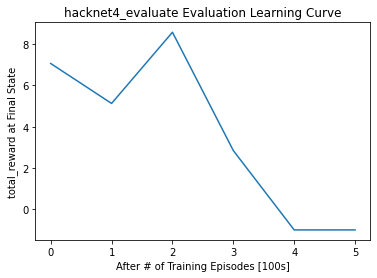

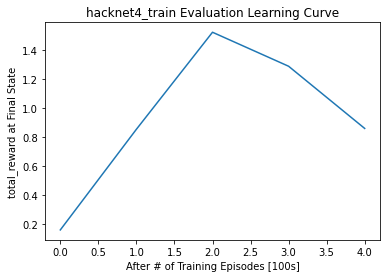

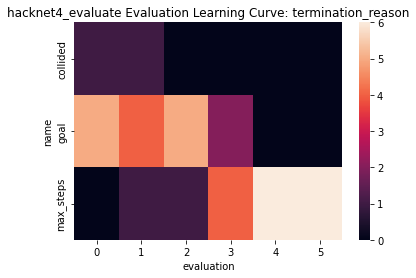

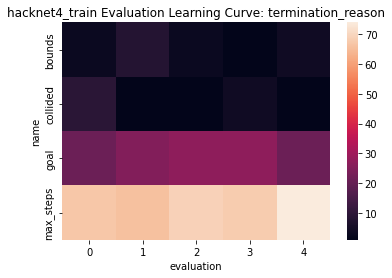

In [11]:

# select which state variables to fetch
numerical_variables = [
        #'nSteps', 
        'total_reward', 
]
string_variables = [
    #'transcribed_action', 
    'termination_reason',
]
all_variables = numerical_variables + string_variables
plots = {}
# take mean values
for variable in all_variables:
    plots[variable] = {}
    for instance in instances:
        plots[variable][instance] = {}
        
        values = {}
        for episode in final_variables[instance][variable]:
            for evaluation in range(len(final_variables[instance][variable][episode])):
                if evaluation not in values:
                    values[evaluation] = []
                values[evaluation].append(final_variables[instance][variable][episode][evaluation])

        if variable in numerical_variables:
            aggregates = []
            nEpisodes = len(final_variables[instance][variable])
            for evaluation in values:
                aggregates.append(sum(values[evaluation])/len(values[evaluation]))
            plt.title(instance + ' Evaluation Learning Curve')
            plt.xlabel('After # of Training Episodes [100s]')
            plt.ylabel(variable + ' at Final State')
            plt.plot(aggregates)
            plt.show()

        if variable in string_variables:
            aggregates = {}
            for evaluation in values:
                for name in values[evaluation]:
                    if name not in aggregates:
                        aggregates[name] = {}
                    if evaluation not in aggregates[name]:
                        aggregates[name][evaluation] = 0
                    aggregates[name][evaluation] += 1   
            df_data = {'count':[], 'name':[], 'evaluation':[]}
            for name in aggregates:
                for evaluation in values:
                    if evaluation not in aggregates[name]:
                        aggregates[name][evaluation] = 0
                    count = aggregates[name][evaluation]
                    df_data['count'].append(count)
                    df_data['name'].append(name)
                    df_data['evaluation'].append(evaluation)
            df = pd.DataFrame(df_data)
            heatmap_data = pd.pivot_table(df, values='count', index=['name'], columns='evaluation')
            sns.heatmap(heatmap_data)
            plt.title(instance + ' Evaluation Learning Curve: ' + variable)
            plt.show()
            
        plots[variable][instance] = aggregates

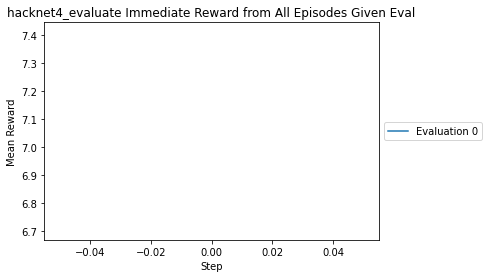

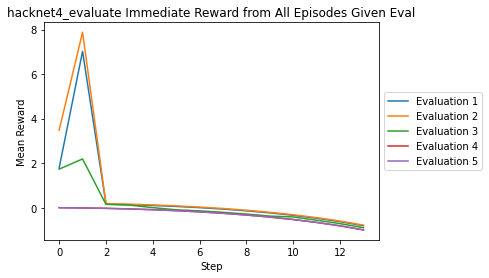

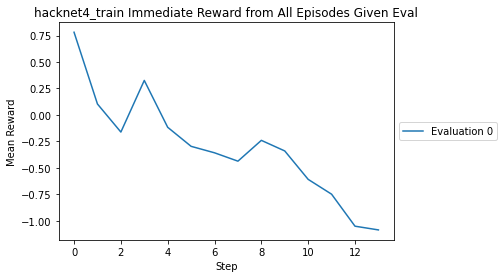

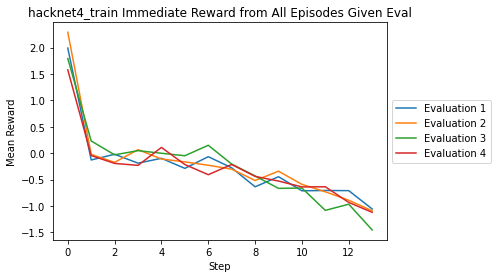

In [12]:
def show_plt(instance):
    plt.title(instance + ' Immediate Reward from All Episodes Given Eval')
    plt.xlabel('Step')
    plt.ylabel('Mean Reward')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
for instance in instances:
    evaluations = all_evaluations[instance]
    for evaluation, episodes in enumerate(evaluations):
        R = 0
        Rs = {}
        n = 0
        for episode, states in enumerate(episodes):
            for step, state in enumerate(states):
                if step == 0:
                    continue
                if step not in Rs:
                    Rs[step] = []
                r = state['total_reward']
                n+=1
                R+=r
                Rs[step].append(r)
        aves = []
        for step in Rs:
            ave = np.mean(Rs[step])
            aves.append(ave)
        plt.plot(aves, label=str('Evaluation ') + str(evaluation))
        if evaluation % 10 == 0:
            show_plt(instance)
    if evaluation % 10 != 0:
        show_plt(instance)

hacknet4_evaluate Total Reward: 76.5889 Confidence: 276 Mean Reward: 0.2775 Dev Reward: 0.09299224642396671


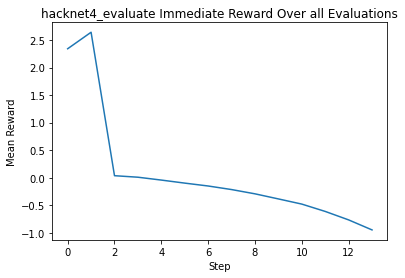

hacknet4_train Total Reward: -1015.0258 Confidence: 5320 Mean Reward: -0.1908 Dev Reward: 0.8262886846635007


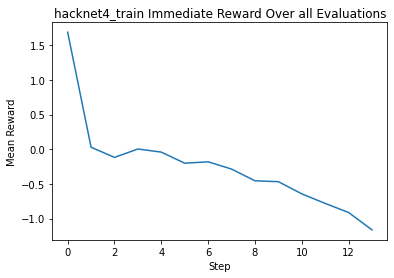

In [13]:
for instance in instances:
    R = 0
    Rs = {}
    n = 0
    evaluations = all_evaluations[instance]
    for evaluation, episodes in enumerate(evaluations):
        for episode, states in enumerate(episodes):
            for step, state in enumerate(states):
                if step == 0:
                    continue
                if step not in Rs:
                    Rs[step] = []
                r = state['total_reward']
                n += 1
                R += r
                Rs[step].append(r)
    print(instance, 'Total Reward:', round(R, 4), 'Confidence:', n, 'Mean Reward:', round(R/n, 4), 'Dev Reward:', np.std(Rs[step]))
    aves = []
    for step in Rs:
        ave = np.mean(Rs[step])
        aves.append(ave)
    plt.plot(aves)
    plt.title(instance + ' Immediate Reward Over all Evaluations')
    plt.xlabel('Step')
    plt.ylabel('Mean Reward')
    plt.show()
    aves[-1]

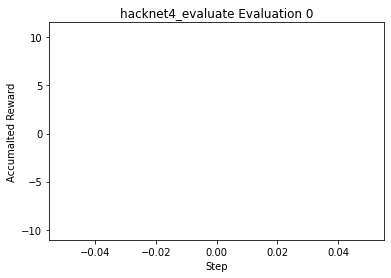

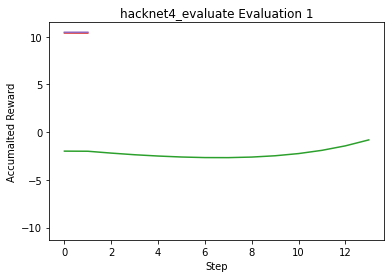

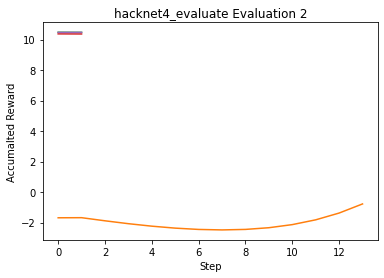

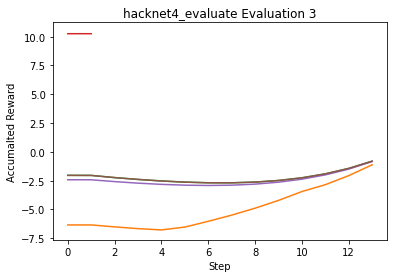

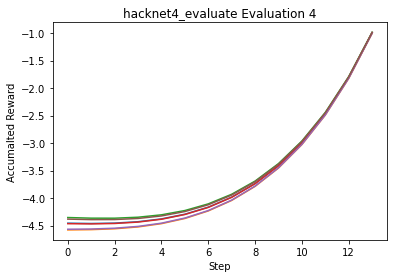

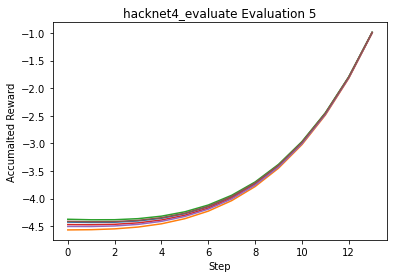

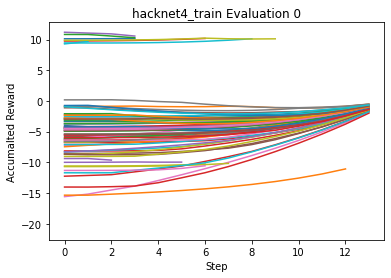

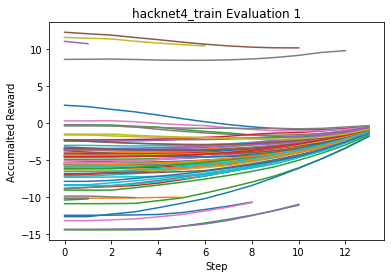

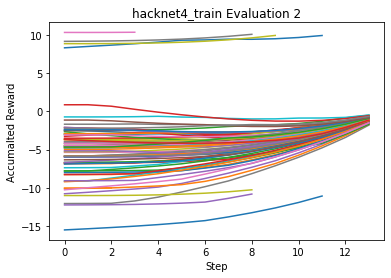

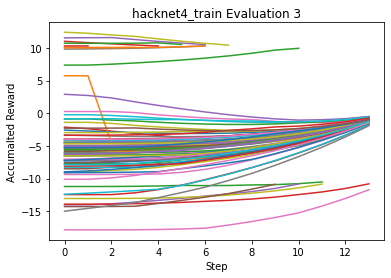

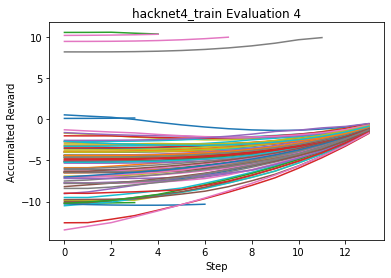

In [14]:
Rs = {}
gamma = 0.9999
for instance in instances:
    evaluations = all_evaluations[instance]
    for evaluation, episodes in enumerate(evaluations):
        Rs[evaluation] = {}
        plt.title(instance + ' Evaluation ' + str(evaluation))
        plt.xlabel('Step')
        plt.ylabel('Accumalted Reward')
        for episode, states in enumerate(episodes):
            Rs[evaluation][episode] = {}
            rs = []
            termination_reason = states[-1]['termination_reason']
            for step, state in enumerate(states):
                if step == 0:
                    continue
                r = state['total_reward']
                for step2, state2 in enumerate(states[step+1:]):
                    r += (gamma**(step2-step)) * state2['total_reward']
                rs.append(r)
            Rs[evaluation][episode] = rs
            plt.plot(rs, label=str(episode) + ' ' + termination_reason)
        #plt.legend()
        plt.show()

In [15]:
# view moves for each evaluation for each episode
bugs = []
for instance in instances:
    for set_num, episodes in enumerate(all_evaluations[instance]):
        for episode, states in enumerate(episodes):
            print('Instance', instance, 'Evaluation Set', set_num, 'Epsode', episode)
            for step, state in enumerate(states):
                if step == 0:
                    continue
                action = state['transcribed_action']
                marker = '-'
                if action == 'MoveForward':
                    marker = 'F'
                if action == 'RotateLeft':
                    marker = 'L'
                if action == 'RotateRight':
                    marker = 'R'
                if action == 'RotateLeft2':
                    marker = 'L'
                if action == 'RotateRight2':
                    marker = 'R'
                print(marker, end=' ')
            termination_reason = states[-1]['termination_reason']
            print(termination_reason, end=' ')
            if termination_reason == 'collided' and len(states) == 2:
                bugs.append((instance, set_num, episode))
            print()

Instance hacknet4_evaluate Evaluation Set 0 Epsode 0
F collided 
Instance hacknet4_evaluate Evaluation Set 0 Epsode 1
F goal 
Instance hacknet4_evaluate Evaluation Set 0 Epsode 2
F goal 
Instance hacknet4_evaluate Evaluation Set 0 Epsode 3
F goal 
Instance hacknet4_evaluate Evaluation Set 0 Epsode 4
F goal 
Instance hacknet4_evaluate Evaluation Set 0 Epsode 5
F goal 
Instance hacknet4_evaluate Evaluation Set 1 Epsode 0
R collided 
Instance hacknet4_evaluate Evaluation Set 1 Epsode 1
F goal 
Instance hacknet4_evaluate Evaluation Set 1 Epsode 2
R F R R R R R R R R R R R R max_steps 
Instance hacknet4_evaluate Evaluation Set 1 Epsode 3
R F goal 
Instance hacknet4_evaluate Evaluation Set 1 Epsode 4
R F goal 
Instance hacknet4_evaluate Evaluation Set 1 Epsode 5
F goal 
Instance hacknet4_evaluate Evaluation Set 2 Epsode 0
F goal 
Instance hacknet4_evaluate Evaluation Set 2 Epsode 1
R F L L L L L L L L L L L L max_steps 
Instance hacknet4_evaluate Evaluation Set 2 Epsode 2
L F goal 
Instance 

In [16]:
bugs

[('hacknet4_evaluate', 0, 0),
 ('hacknet4_evaluate', 1, 0),
 ('hacknet4_train', 0, 8),
 ('hacknet4_train', 0, 11),
 ('hacknet4_train', 0, 14),
 ('hacknet4_train', 0, 24),
 ('hacknet4_train', 0, 44)]

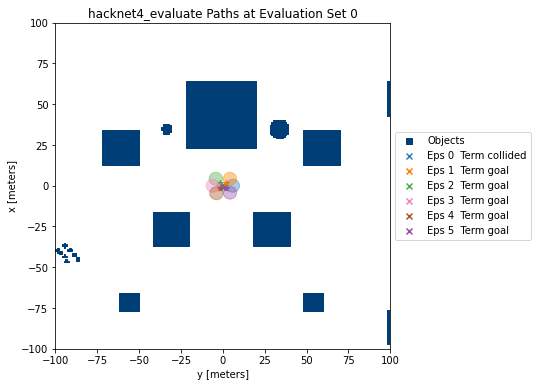

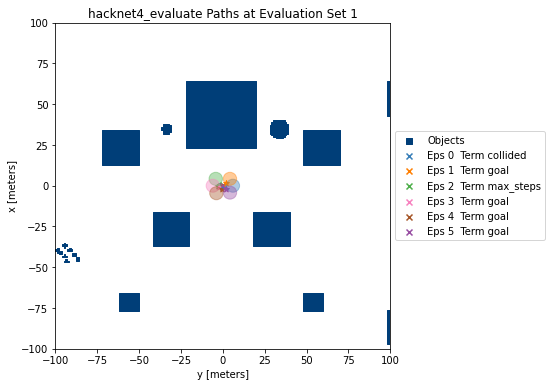

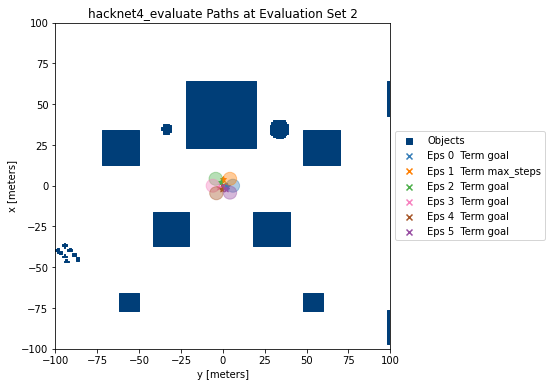

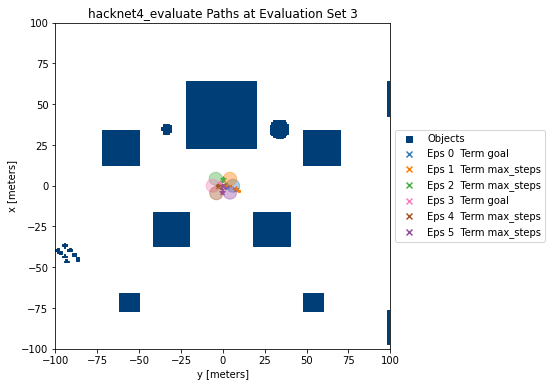

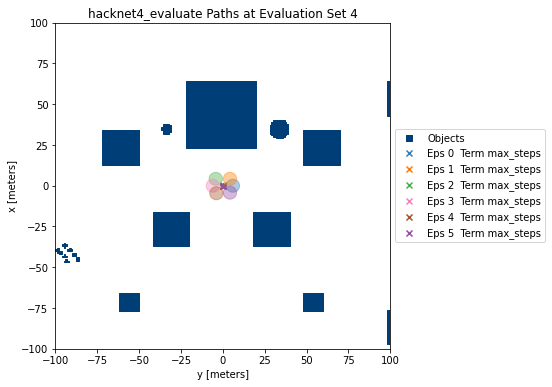

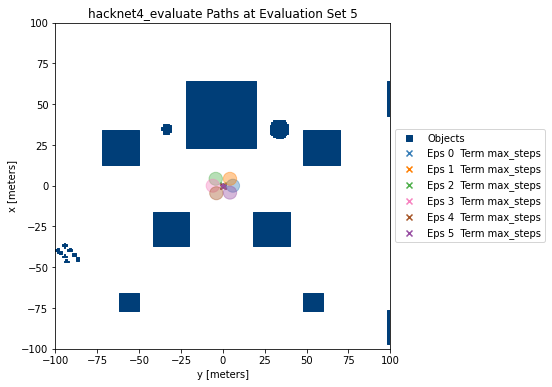

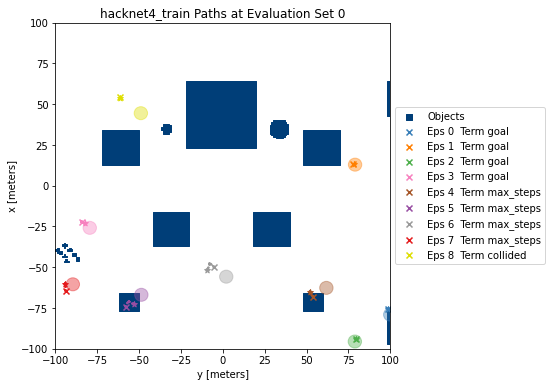

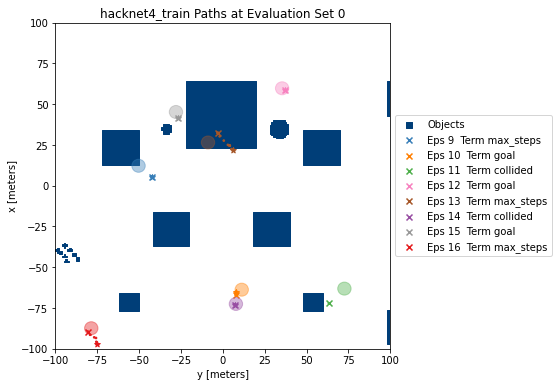

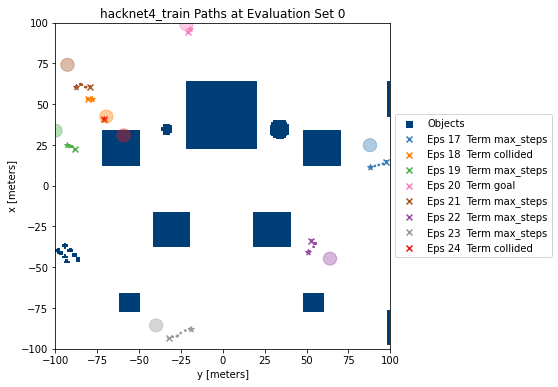

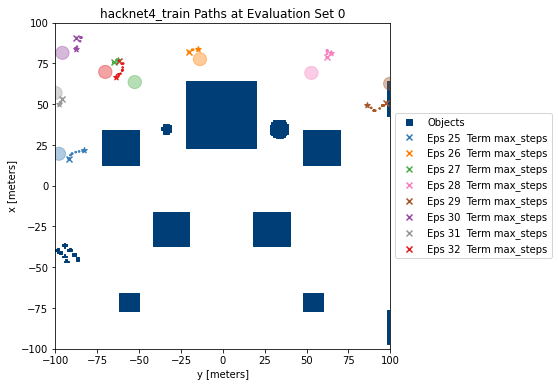

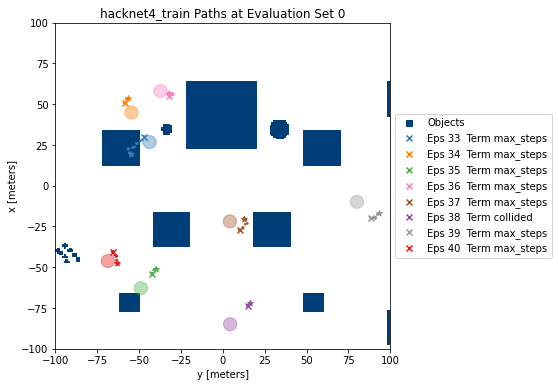

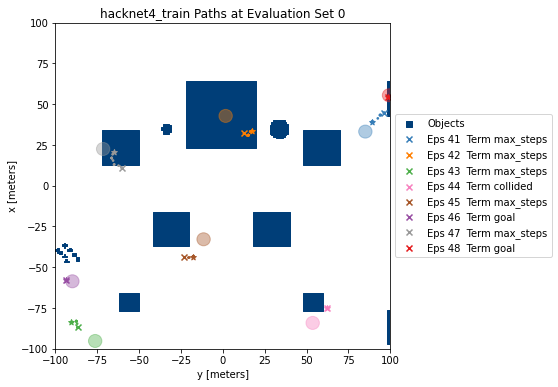

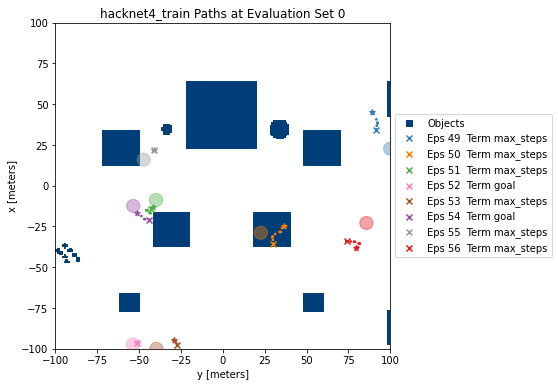

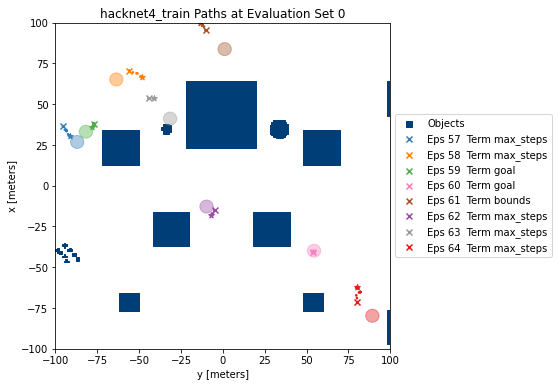

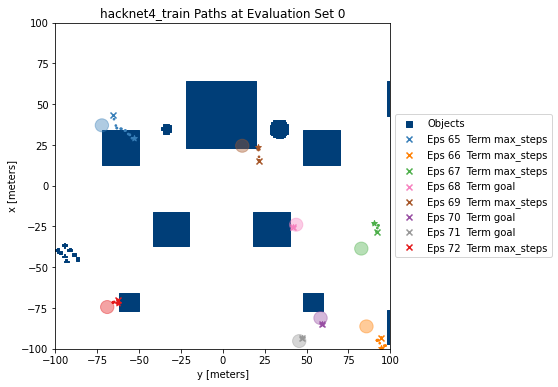

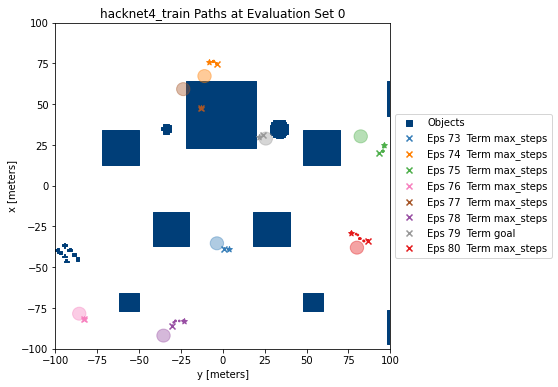

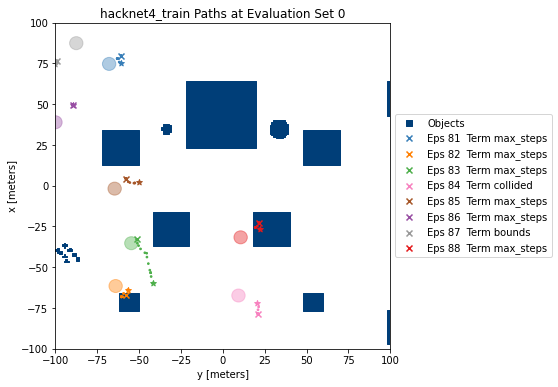

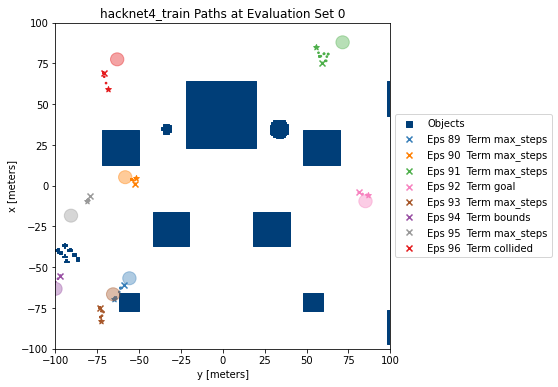

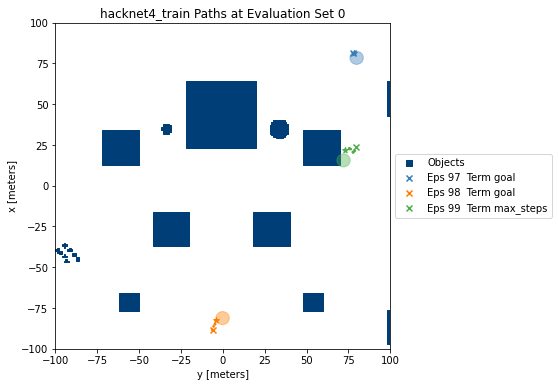

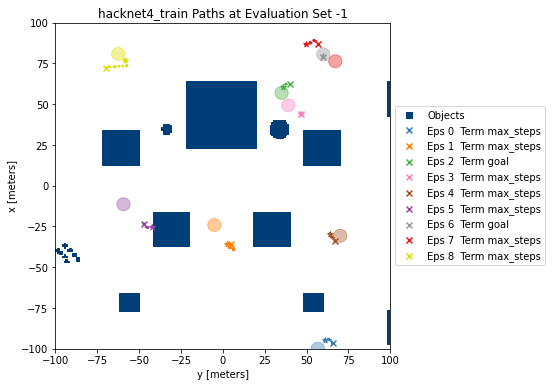

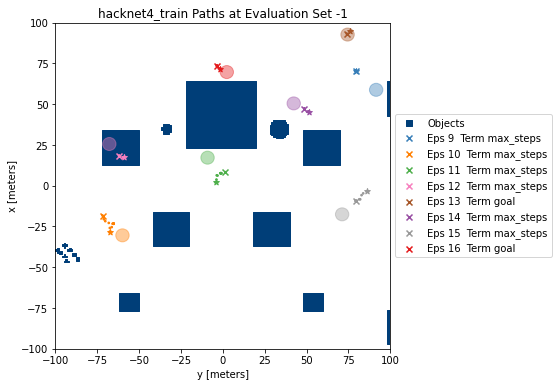

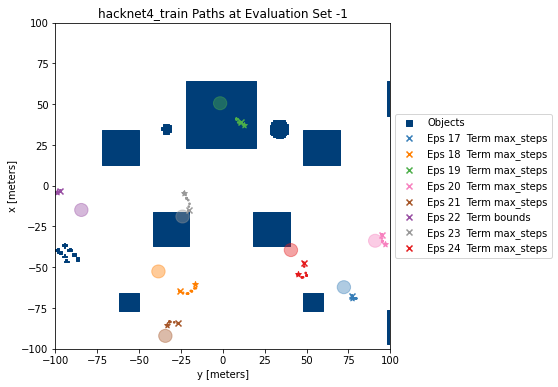

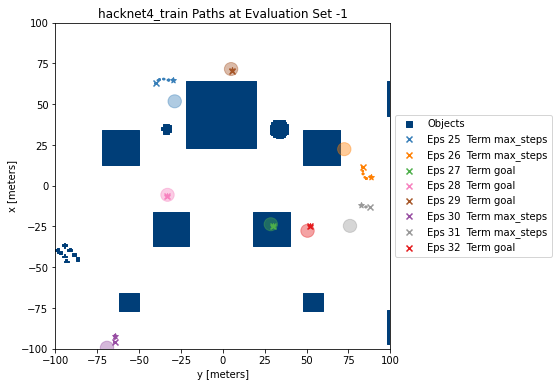

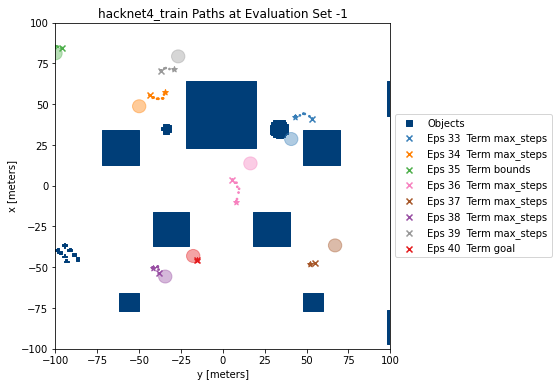

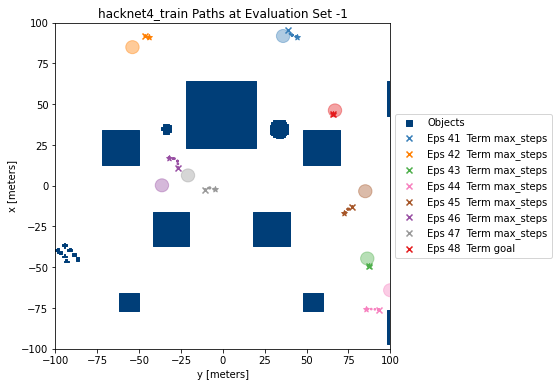

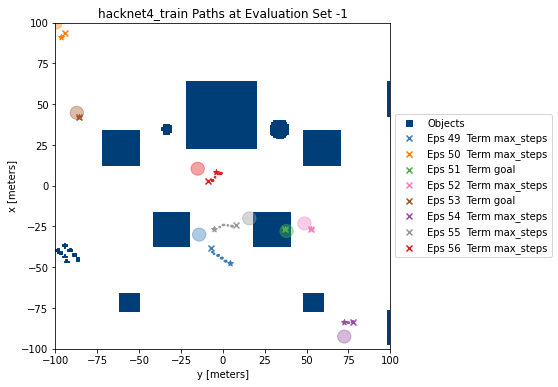

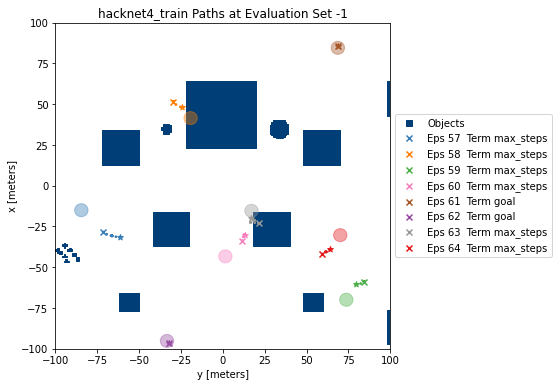

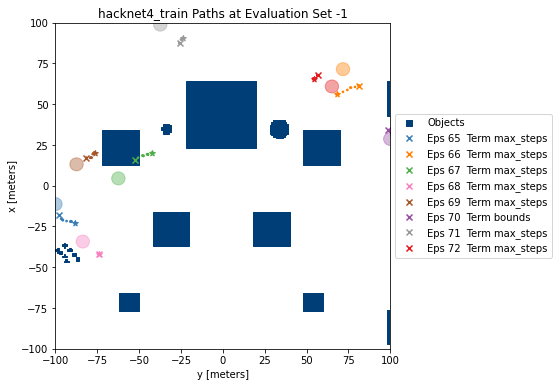

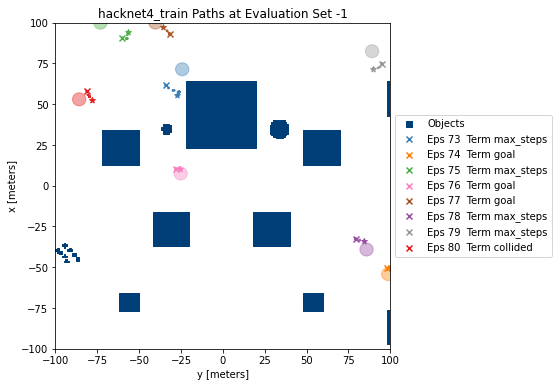

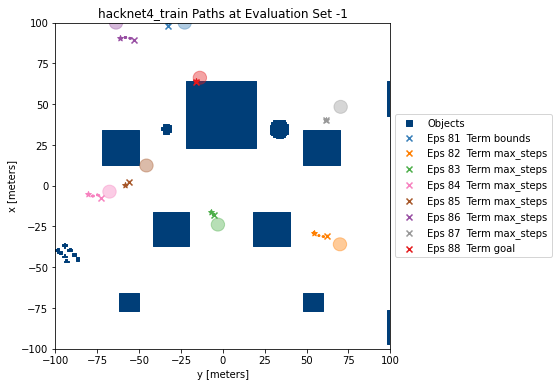

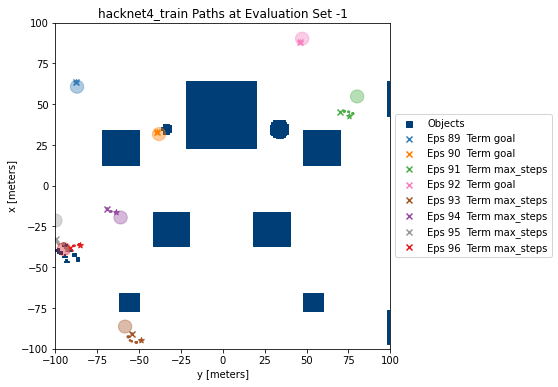

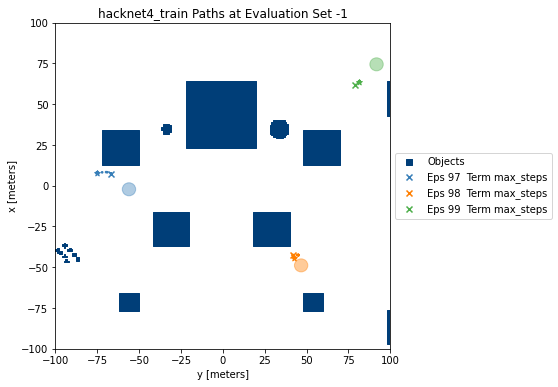

In [19]:
# plot final paths (run necessary binvox stuff at bottom of notebook to use plot_map)
for instance in instances:
    evaluations = all_evaluations[instance]
    if 'train' in instance:
        evaluations = [evaluations[0]] + [evaluations[-1]]
    for set_num, episodes in enumerate(evaluations):
        paths = []
        goals = []
        termination_reasons = []
        episode_numbers = []
        for episode, states in enumerate(episodes):
            path = []
            episode_numbers.append(episode)
            # get initial value
            init_state = states[0]
            goal = init_state['goal_position']
            goals.append(goal)
            # get intermediate values
            for step, state in enumerate(states):
                state = episodes[episode][step]
                drone_position = state['drone_position']
                path.append(drone_position)
            paths.append(path)
            # get final vaules
            final_state = episodes[episode][-1]
            termination_reason = final_state['termination_reason']
            termination_reasons.append(termination_reason)
            # plot every 8 episodes 
            if episode == len(episodes)-1 or (episode > 0 and episode%8 == 0):
                # make plot
                fig = plt.figure()
                fig.set_size_inches((6, 6))
                if 'train' in instance:
                    plt.title(instance + ' Paths at Evaluation Set ' + ('0' if set_num == 0 else '-1'))
                else:
                    plt.title(instance + ' Paths at Evaluation Set ' + str(set_num))
                plt.xlabel('y [meters]')
                plt.ylabel('x [meters]')
                plt.xlim(-100, 100)
                plt.ylim(-100, 100)
                # show objects on map from binvox
                plot_map()
                # legend hack
                plt.scatter(-999, -999, marker='s', color=object_color) # off map just for legend
                legend = ['Objects']
                for idx in range(len(termination_reasons)):
                    color = color_blinds_list[idx]
                    plt.scatter(paths[idx][0][0], paths[idx][0][1], marker='x', color=color) # spawn location
                    termination_reason = termination_reasons[idx]
                    legend.append('Eps ' + str(episode_numbers[idx]) + '  Term ' + termination_reason)
                plt.legend(legend, loc='center left', bbox_to_anchor=(1, 0.5))
                # plot paths
                plt_patches = []
                for idx in range(len(termination_reasons)):
                    color = color_blinds_list[idx]
                    # plot goal
                    obj = plt.Circle((goals[idx][0], goals[idx][1]), 4, color=color, alpha=0.4)
                    plt_patches.append(obj)
                    # plot points
                    for point in paths[idx]:
                        # using generic quad copter size for point sizes (set this to your drone value)
                        radius = 0.5
                        point = plt.Circle((point[0], point[1]), radius, color=color)
                        plt_patches.append(point)
                    # plot end point
                    plt.scatter(paths[idx][-1][0], paths[idx][-1][1], marker='*', color=color) # end location
                map_stuff = PatchCollection(plt_patches, match_original=True)
                plt.gca().add_collection(map_stuff)
                plt.show()
                paths = []
                goals = []
                termination_reasons = []
                episode_numbers = []

hacknet4_evaluate


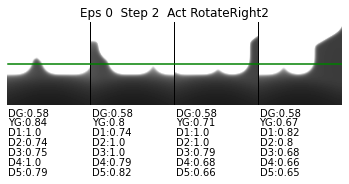

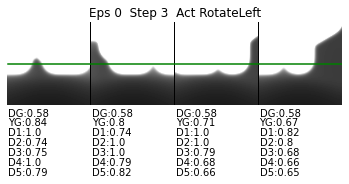

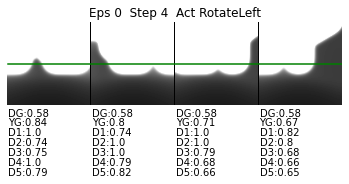

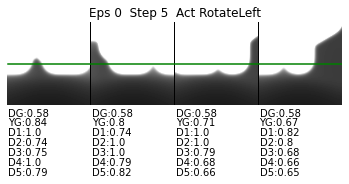

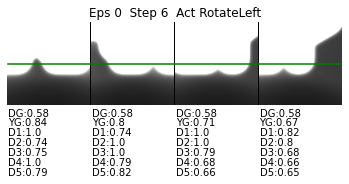

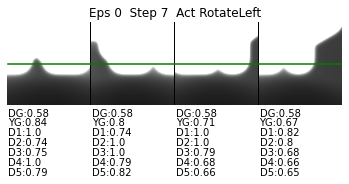

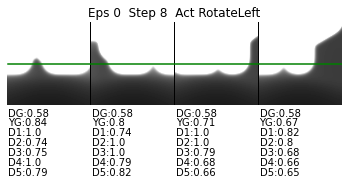

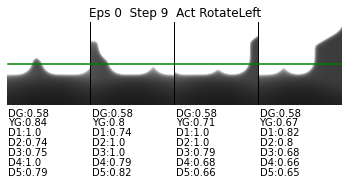

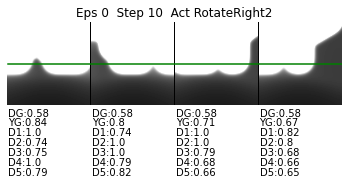

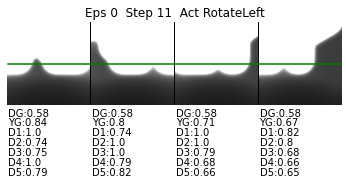

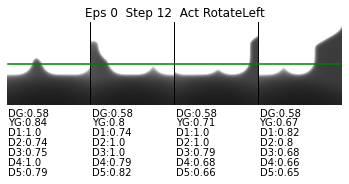

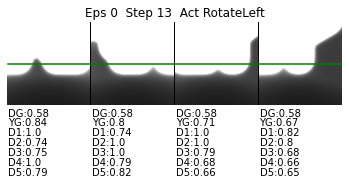

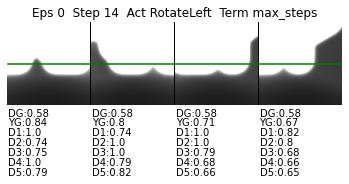

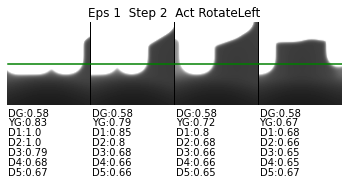

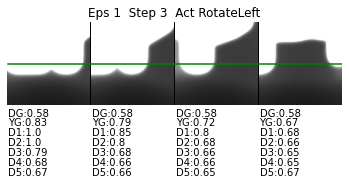

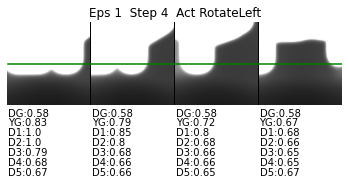

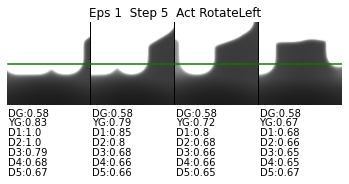

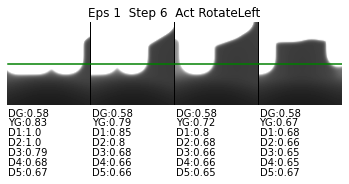

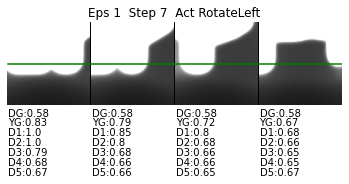

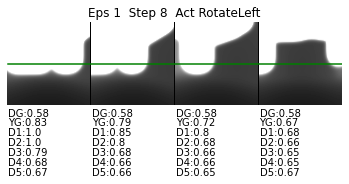

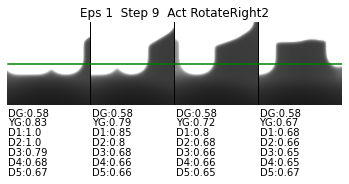

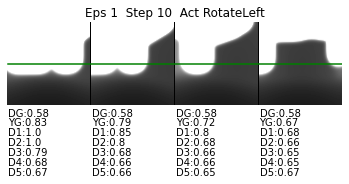

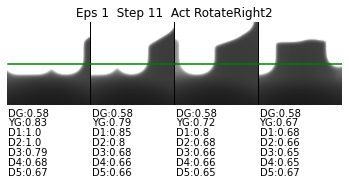

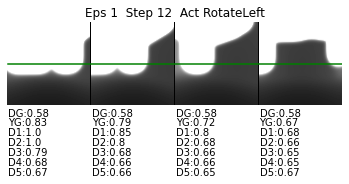

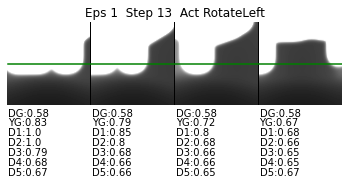

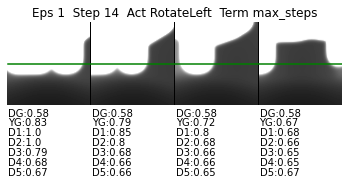

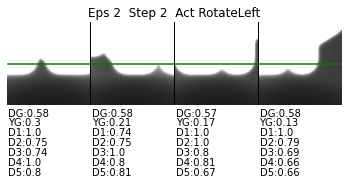

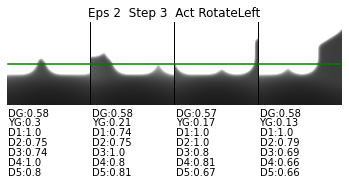

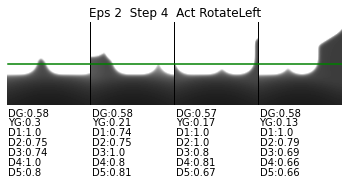

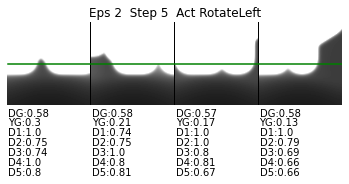

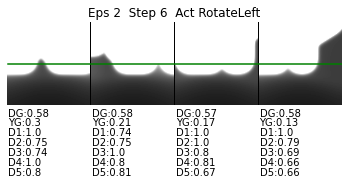

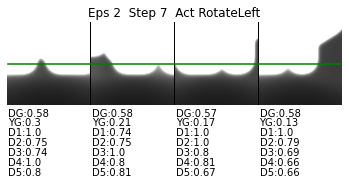

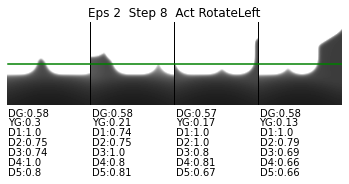

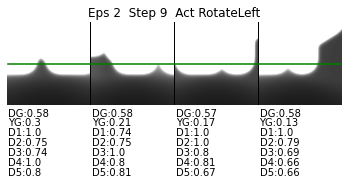

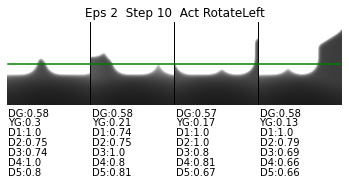

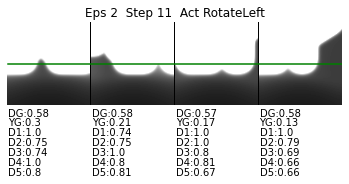

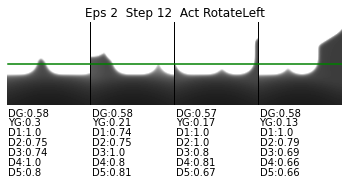

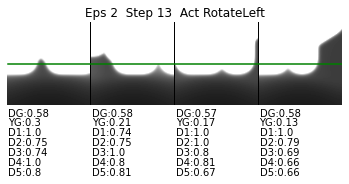

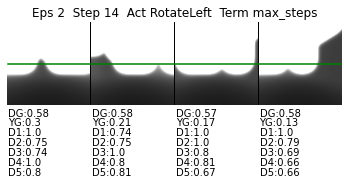

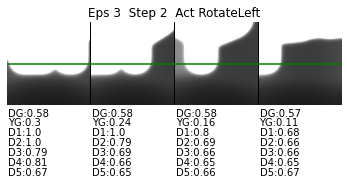

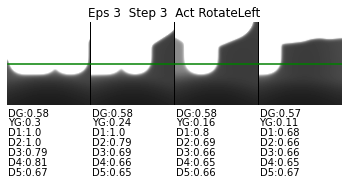

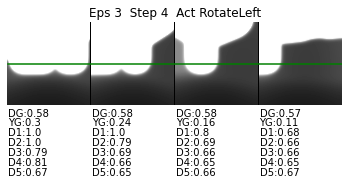

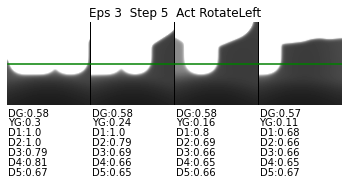

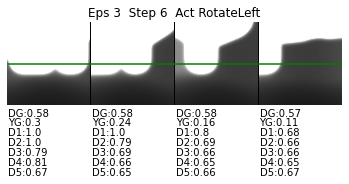

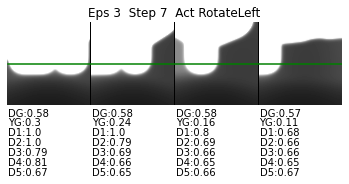

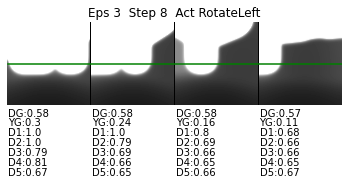

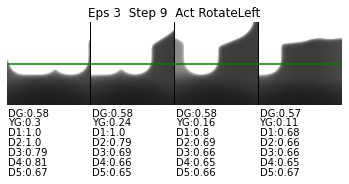

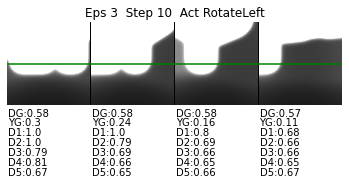

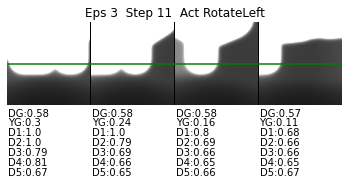

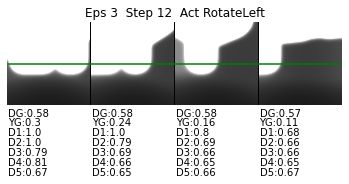

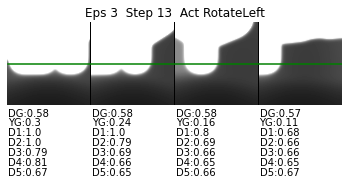

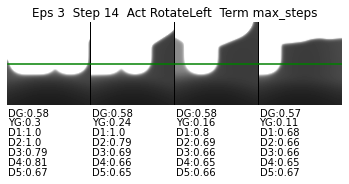

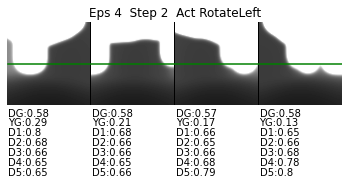

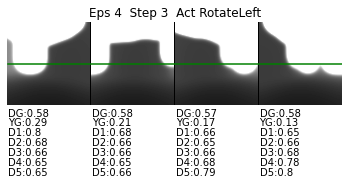

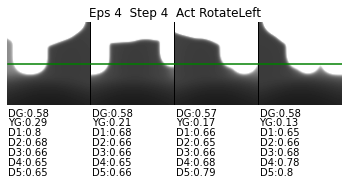

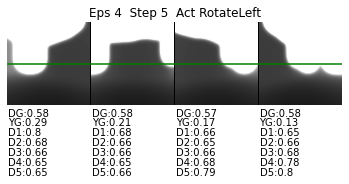

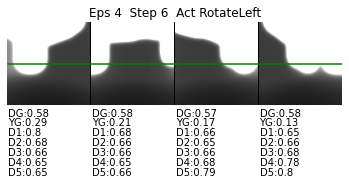

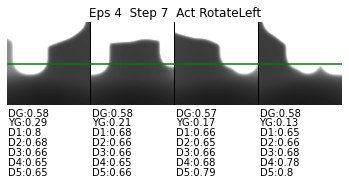

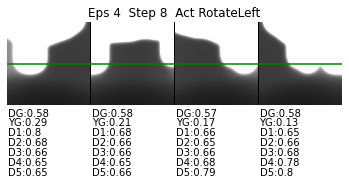

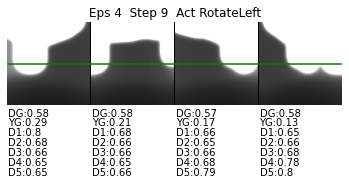

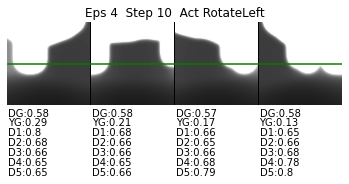

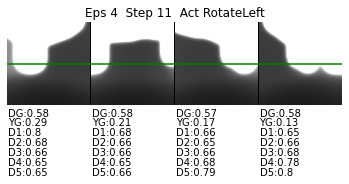

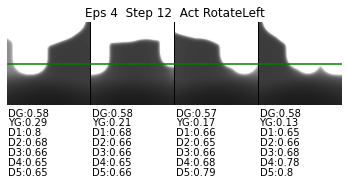

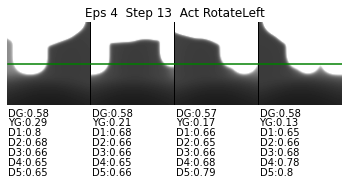

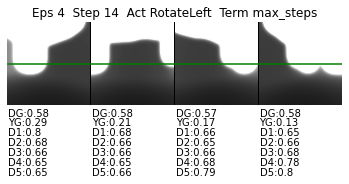

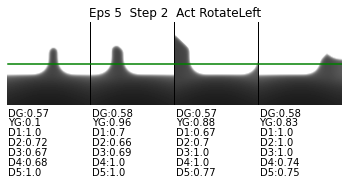

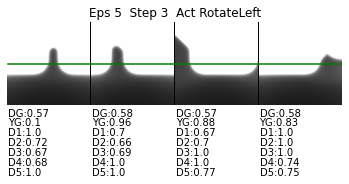

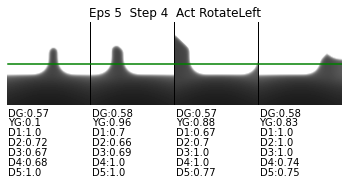

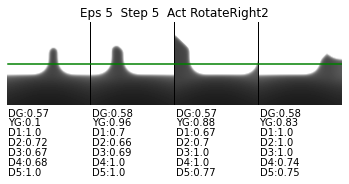

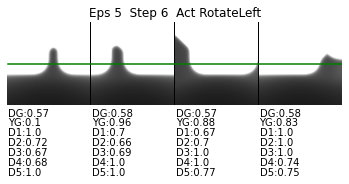

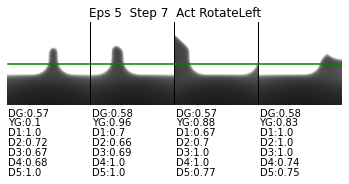

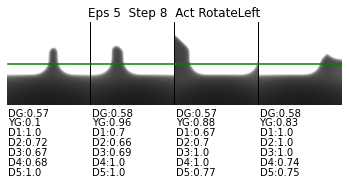

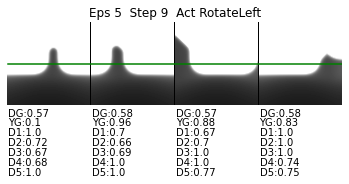

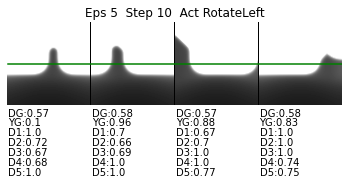

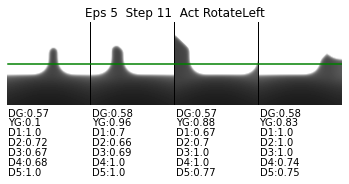

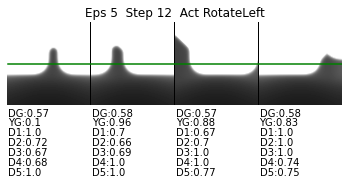

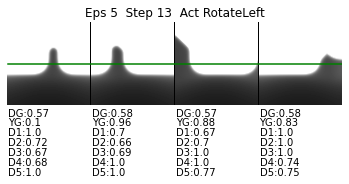

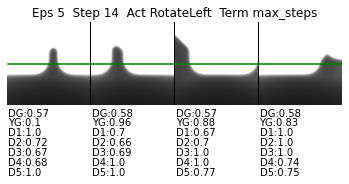

hacknet4_train


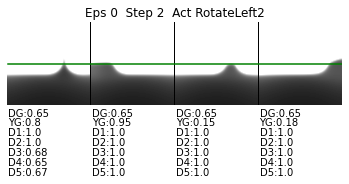

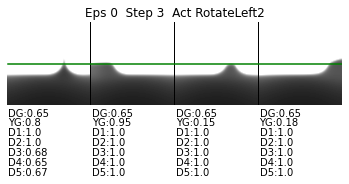

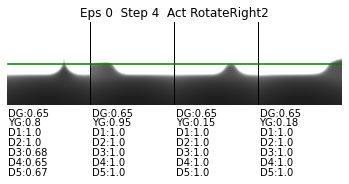

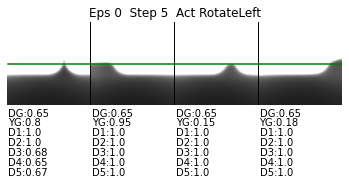

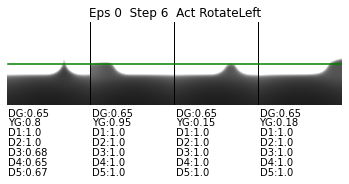

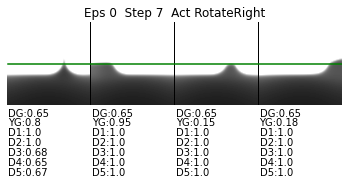

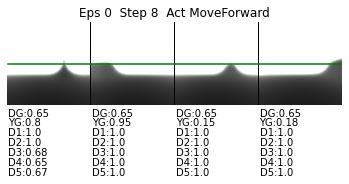

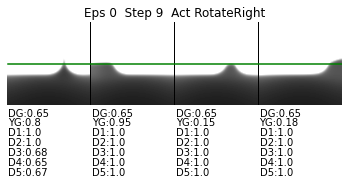

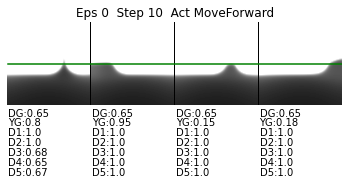

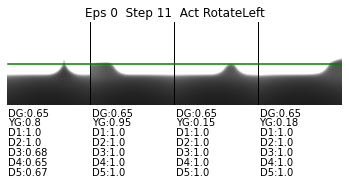

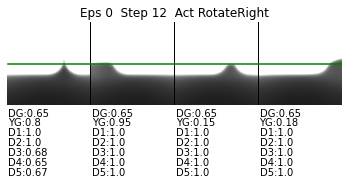

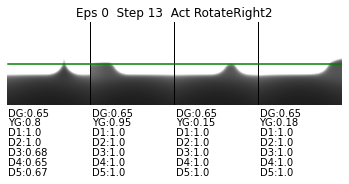

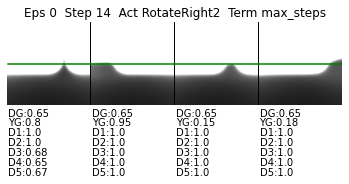

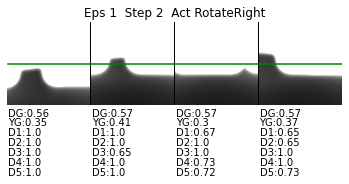

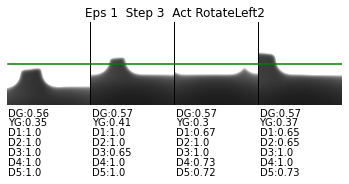

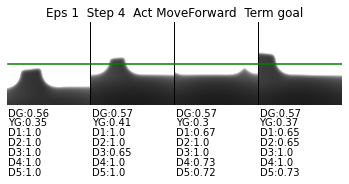

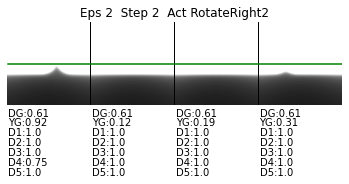

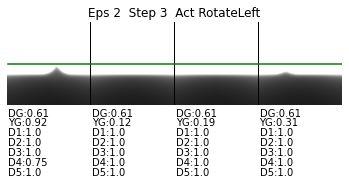

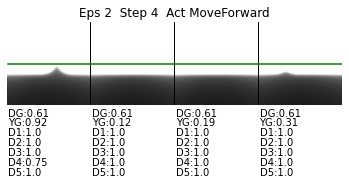

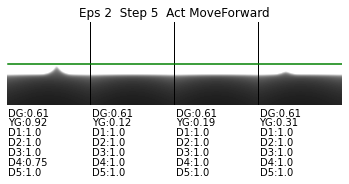

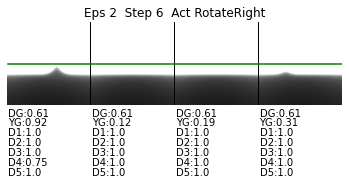

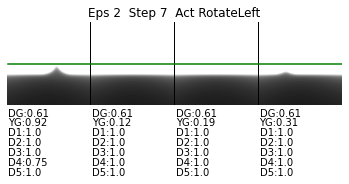

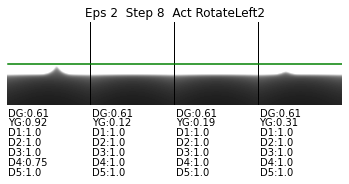

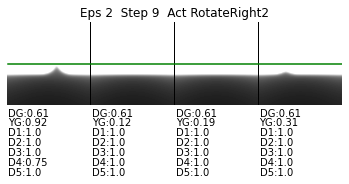

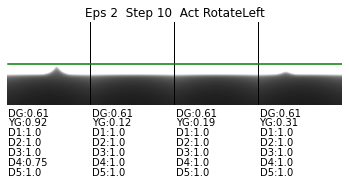

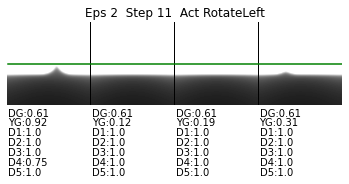

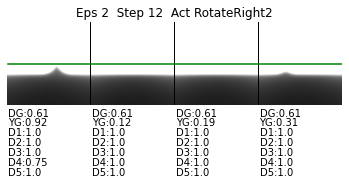

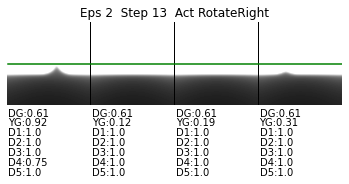

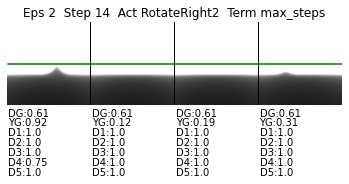

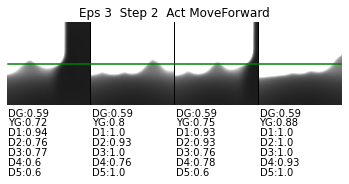

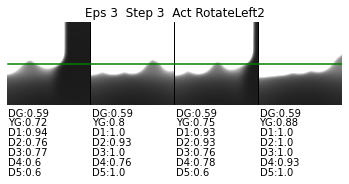

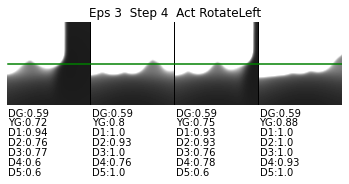

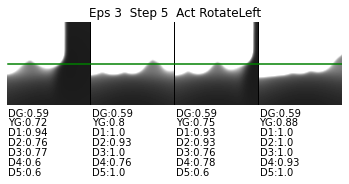

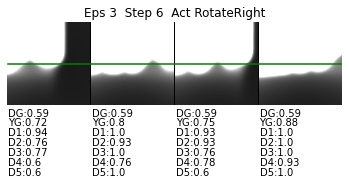

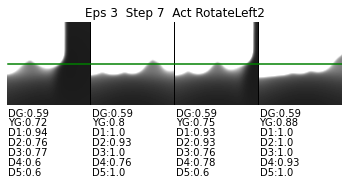

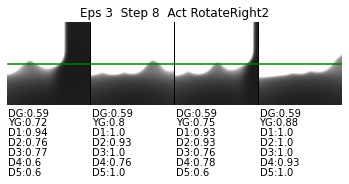

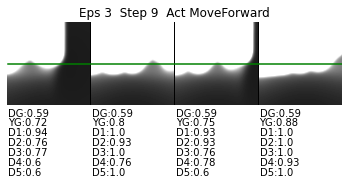

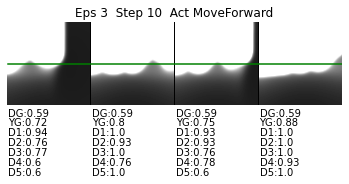

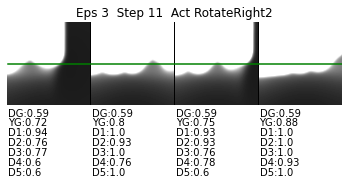

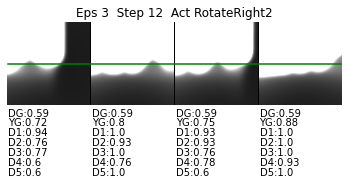

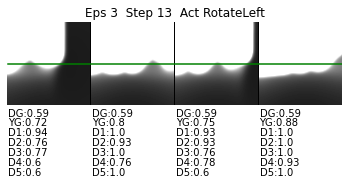

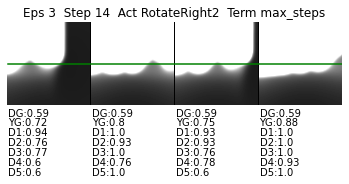

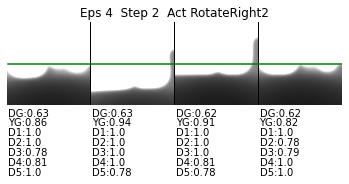

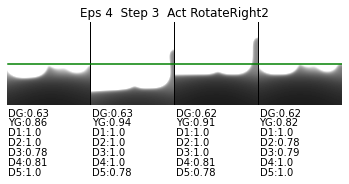

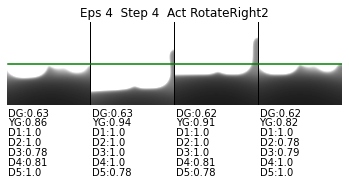

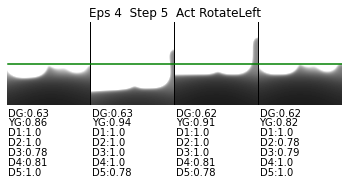

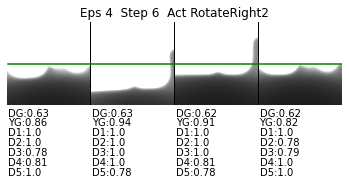

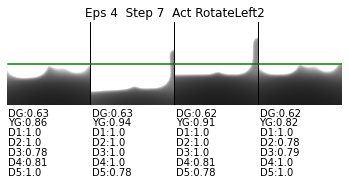

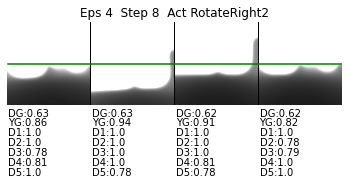

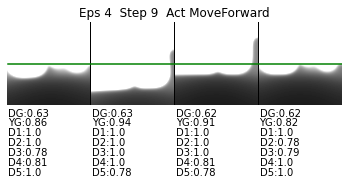

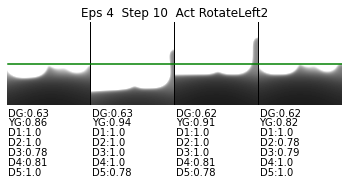

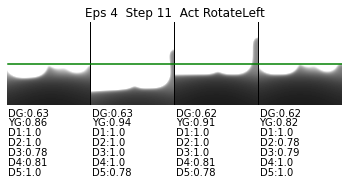

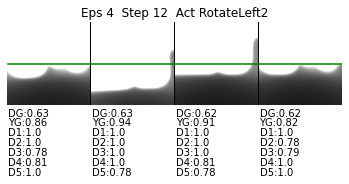

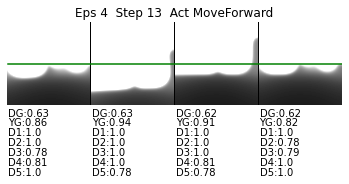

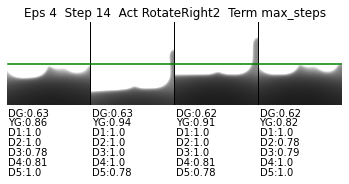

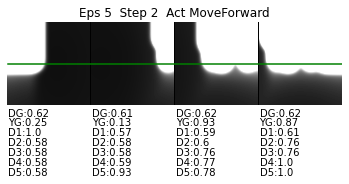

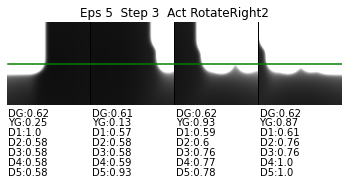

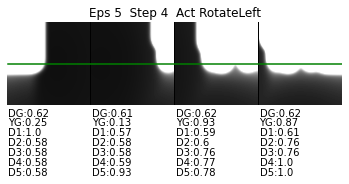

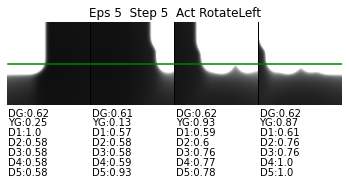

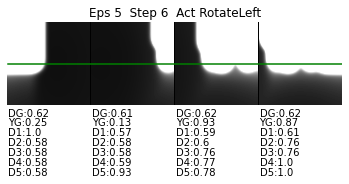

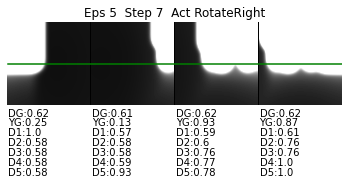

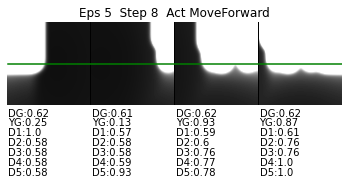

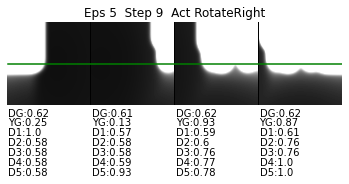

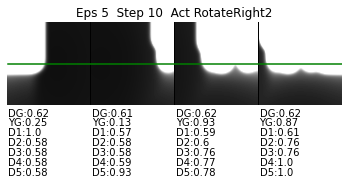

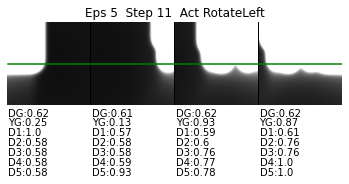

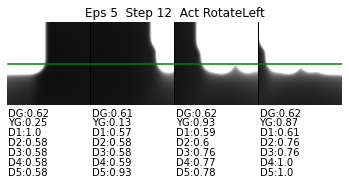

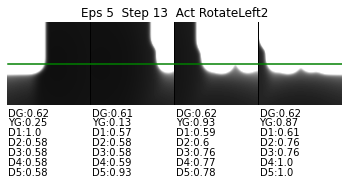

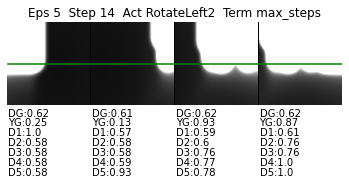

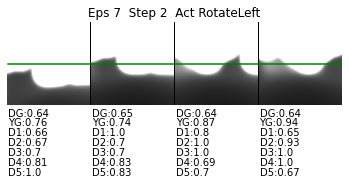

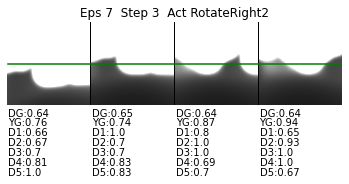

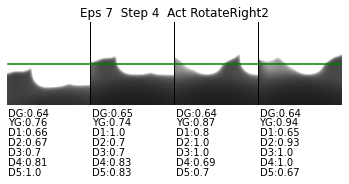

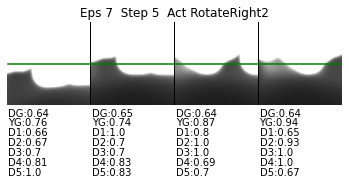

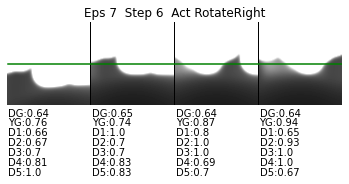

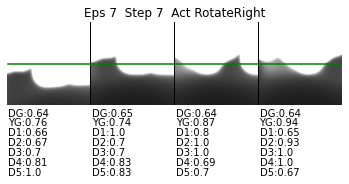

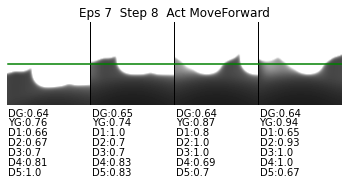

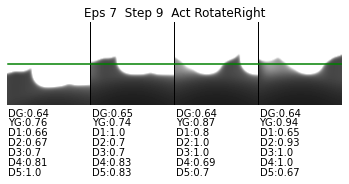

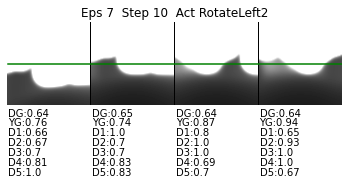

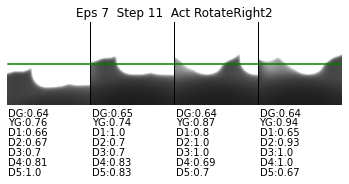

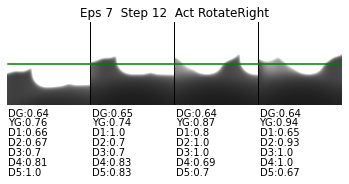

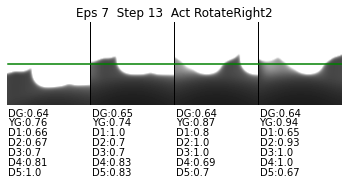

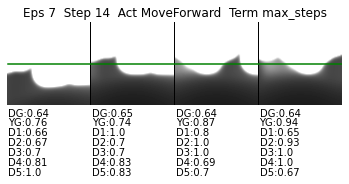

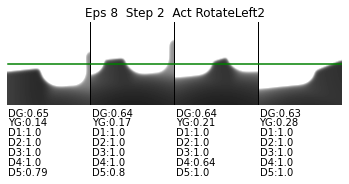

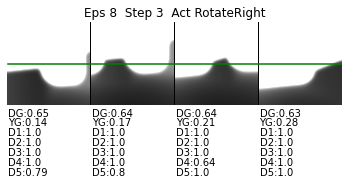

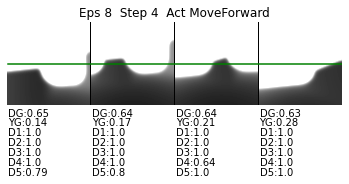

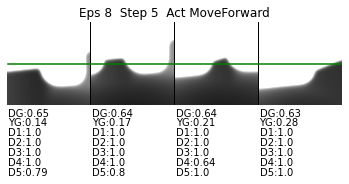

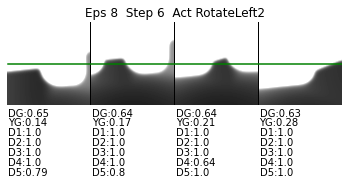

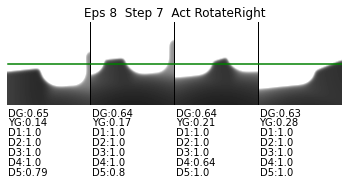

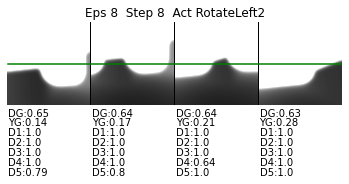

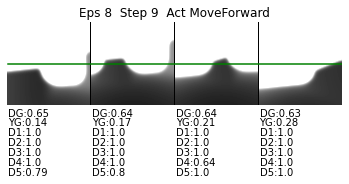

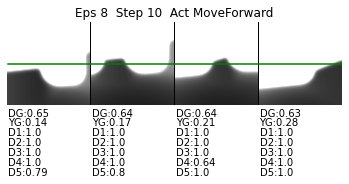

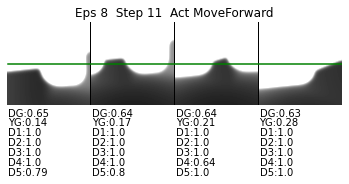

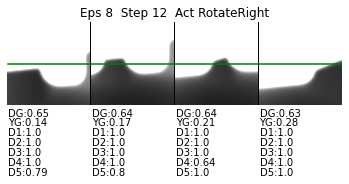

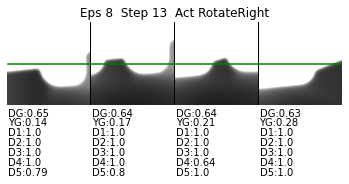

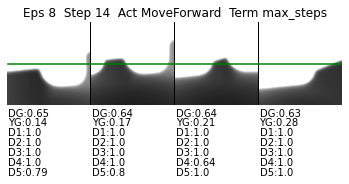

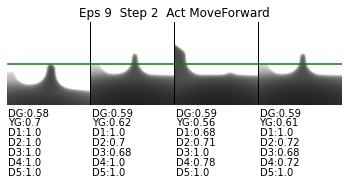

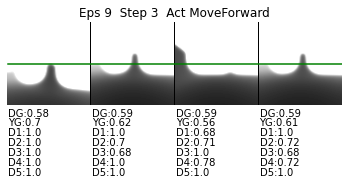

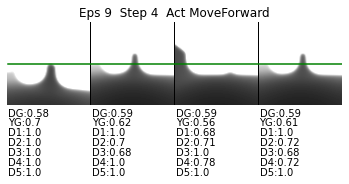

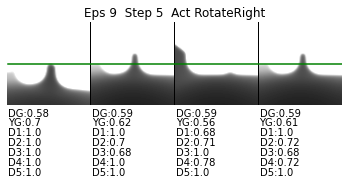

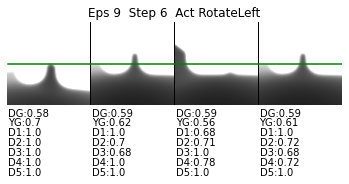

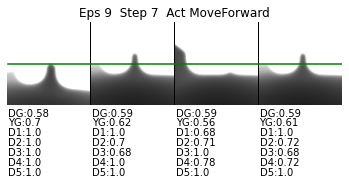

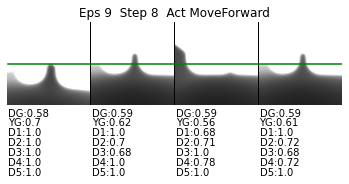

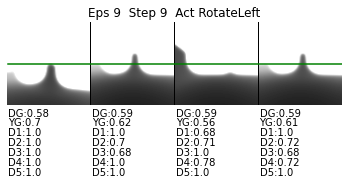

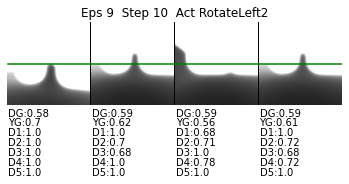

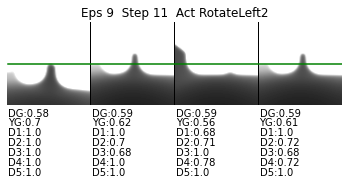

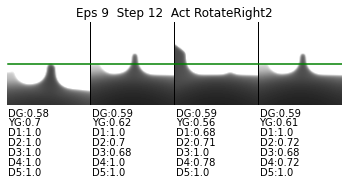

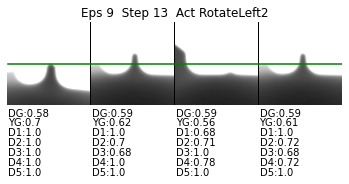

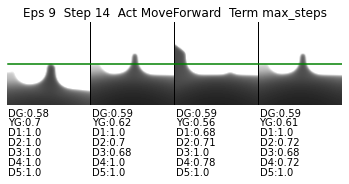

In [38]:
vec_names = ['DG', 'YG', 'D1', 'D2', 'D3', 'D4', 'D5']
nVec = len(vec_names)
vecPad = 10
for instance in instances:
    print(instance)
    directory = instance_paths[instance]
    slideshow_path = directory + 'slideshow/'
    if not os.path.exists(slideshow_path):
        os.mkdir(slideshow_path)
    # read observations
    files = [file for file in os.listdir(directory) if 'observations' in file]
    observations = {}
    for file in files:
        observation_set = np.load(directory + file, allow_pickle=True)
        observations.update(observation_set)
    # plot slides and save as png files
    slides = []
    evaluations = all_evaluations[instance]
    for evaluation, episodes in enumerate(evaluations[-2:-1]):
        if 'train' in instance:
            episodes = episodes[0:10]
        for episode, states in enumerate(episodes):
            for step, state in enumerate(states):
                if step == 0:
                    continue
                # get state values
                transcribed_action = state['transcribed_action']
                done = state['done']
                if done:
                    termination_reason = state['termination_reason']
                observation_key = state['observation_component']
                # get observation and params
                if observation_key not in observations:
                    continue
                observation = observations[observation_key]
                vec_array = observation.item()['vec']
                img_array = observation.item()['img']
                nBands = img_array.shape[0]
                nRows = img_array.shape[1]
                nCols = img_array.shape[2]
                view_shape = (nRows, nBands * nCols + nBands - 1)
                # view side by side
                side_by_side = np.zeros(view_shape, dtype=np.int16)
                side_by_side
                for band in range(nBands):
                    side_by_side[0:nRows, (band*nCols+band):(band*nCols+band)+nCols] = img_array[band]
                plt.plot([0, view_shape[1]], [42, 42], color='green')
                plt.imshow(side_by_side, cmap='gray')
                plt.axis('off')
                x = 0
                for time in range(nBands):
                    y = nRows + vecPad
                    for i, name in enumerate(vec_names):
                        value = vec_array[time*nVec + i]
                        plt.text(x, y, name + ':' + str(round(value, 2)))
                        y += vecPad
                    x += nCols + 1
                title = 'Eps ' + str(episode) + '  Step ' + str(step) + '  Act ' + transcribed_action
                title += '' if not done else '  Term ' + termination_reason
                plt.title(title)
                slide_name = title + '.png'
                plt.savefig(slideshow_path + slide_name)
                slides.append(slide_name)
                plt.show()      
                
    # make video from frames
    frames = []
    for slide_name in slides:
        frame_path = slideshow_path + slide_name
        frame = cv2.imread(frame_path)
        frame_shape = frame.shape
        frames.append(frame)
    video_path = slideshow_path + instance + '_slideshow.avi'
    video = cv2.VideoWriter(
                            filename = video_path, 
                            fourcc = 0,
                            fps = 1,
                            frameSize = (frame_shape[1], frame_shape[0]),
                            isColor = True,
                           )
    for frame in frames:
        video.write(frame)
    video.release()